In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_curve, roc_auc_score, log_loss
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.4f}'.format
sns.set()

In [2]:
df = pd.read_csv('titanic_train.csv')

In [3]:
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0000,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0000,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0000,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
def dfDescribe(df):
    pd.set_option("display.float_format", "{:.3f}".format)
    dfDesc = df.describe().T.iloc[:, [0,1,2,3,7]]
    dfNull = pd.DataFrame(df.isnull().sum(), columns=['null'])
    dfType = pd.DataFrame(df.dtypes, columns=['dtype'])
    dfInfo = pd.concat([dfDesc, dfNull, dfType], ignore_index=False, axis=1)
    dfInfo.loc[:,'zero_'] = [(df[df[col] == 0][col].count() / len(df[col])) for col in dfInfo.index]
    dfInfo.loc[:,'nunique'] = [(df[col].nunique()) for col in dfInfo.index]
    dfInfo.loc[:,'freq'] = [(df[col].value_counts().sort_values(ascending=False).values[0]) for col in dfInfo.index]
    dfInfo.loc[:,'top'] = [(df[col].value_counts().sort_values(ascending=False).index[0]) for col in dfInfo.index]

    for col in dfInfo.index:
        if dfInfo.loc[col, 'dtype'] != str('object'):
            Q1=df[col].quantile(q=0.25)
            Q3=df[col].quantile(q=0.75)
            lowOutliers=Q1-1.5*(Q3-Q1)
            upperOutliers=Q3+1.5*(Q3-Q1)
            dfInfo.loc[col, 'upout_'] = (df[df[col]>upperOutliers][col].count()*100/len(df))
            dfInfo.loc[col, 'lowout_'] = (df[df[col]<lowOutliers][col].count()*100/len(df))
            #dfInf.style.format({'count': "{:.0f}",'upOut': "{:.0f}",'lowOut': "{:.0f}"})

    return dfInfo

In [5]:
dfDescribe(df)

,count,mean,std,min,max,null,dtype,zero_,nunique,freq,top,upout_,lowout_
PassengerId,891.000,446.000,257.354,1.000,891.000,0,int64,0.000,891,1,1,0.000,0.000
Survived,891.000,0.384,0.487,0.000,1.000,0,int64,0.616,2,549,0,0.000,0.000
Pclass,891.000,2.309,0.836,1.000,3.000,0,int64,0.000,3,491,3,0.000,0.000
Age,714.000,29.699,14.526,0.420,80.000,177,float64,0.000,88,30,24.000,1.235,0.000
SibSp,891.000,0.523,1.103,0.000,8.000,0,int64,0.682,7,608,0,5.163,0.000
Parch,891.000,0.382,0.806,0.000,6.000,0,int64,0.761,7,678,0,23.906,0.000
Fare,891.000,32.204,49.693,0.000,512.329,0,float64,0.017,248,43,8.050,13.019,0.000
Name,nan,nan,nan,nan,nan,0,object,0.000,891,1,"Otter, Mr. Richard",nan,nan
Sex,nan,nan,nan,nan,nan,0,object,0.000,2,577,male,nan,nan
Ticket,nan,nan,nan,nan,nan,0,object,0.000,681,7,1601,nan,nan


In [6]:
def dfCleaner(df):
    df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 1) #Rare
    df['Title'] = df['Title'].replace(['Mlle', 'Ms', 'Miss'], 2) #Miss
    df['Title'] = df['Title'].replace(['Mme', 'Mrs'], 3) #Mrs
    df['Title'] = df['Title'].replace('Mr', 4) #Mr
    df['Title'] = df['Title'].replace('Master', 5) #Master
    
    df['Cabin'] = df.Cabin.str.extract('([A-Z])', expand=False)
    df['Cabin'] = df.Cabin.fillna('U')
    df['Cabin'] = df.Cabin.replace({'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'T':8, "U":8})
    
    df['Embarked'] = df.Embarked.fillna("C")
    df['Embarked'] = df.Embarked.replace({'C':1, 'S':2, 'Q':3})
    
    df['Family'] = df['SibSp'] + df['Parch']
    df['Age'] = df.Age.fillna(0)
    df['Sex'] = df.Sex.replace({'male':1, "female":0})

    df = df.drop(['PassengerId', 'Ticket', 'Name', 'SibSp', 'Parch'], axis=1)
    return df
df = dfCleaner(df)

In [7]:
df.head(3)

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Family
0,0,3,1,22.000,7.250,8,2,4,1
1,1,1,0,38.000,71.283,3,1,3,1
2,1,3,0,26.000,7.925,8,2,2,0


In [20]:
Y = df['Survived']
X = df[['Pclass', 'Sex', 'Age', 'Fare', 'Cabin', 'Embarked', 'Title', 'Family']]

def cValue(X, Y):
    c_values = [0.001,0.01,0.1,1,10,100, 1000]
    t_values = pd.DataFrame(columns=['c_values', 't_train', 't_test'])
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
    
    standardscaler = StandardScaler()
    x_train = standardscaler.fit_transform(x_train)
    x_test = standardscaler.transform(x_test)
    
    for c in c_values:
        lr = LogisticRegression(solver='liblinear', penalty = 'l2', C = c, random_state = 0).fit(x_train, y_train)
        t_values = t_values.append({'c_values': c, 't_train' : lr.score(x_train, y_train), 't_test': lr.score(x_test, y_test)}, ignore_index=True)

    return t_values
cValue(X, Y)

,c_values,t_train,t_test
0,0.0010,0.7556,0.7709
1,0.0100,0.7809,0.7821
2,0.1000,0.8006,0.7989
3,1.0000,0.8062,0.8045
4,10.0000,0.8076,0.8045
5,100.0000,0.8076,0.8045
6,1000.0000,0.8076,0.8045


In [9]:
Y = df['Survived']
X = [df[['Pclass', 'Sex', 'Age', 'Fare', 'Cabin', 'Embarked', 'Title', 'Family']],
     df[['Pclass', 'Age', 'Fare', 'Cabin', 'Embarked', 'Title', 'Family']],
     df[['Pclass', 'Sex', 'Age', 'Fare', 'Cabin', 'Title']]]

def logrValue(X, Y):
    t_values = pd.DataFrame(columns=['model', 'or_train', 'or_test', 'mn_train', 'mn_test'])  
    pd.options.display.float_format = '{:.3f}'.format
    
    for num,col in enumerate(X,1): 
        x_train, x_test, y_train, y_test = train_test_split(col, Y, test_size = 0.20, random_state = 42)
        
        standardscaler = StandardScaler()
        x_train = standardscaler.fit_transform(x_train)
        x_test = standardscaler.transform(x_test)
        
        logrOne = LogisticRegression(solver='liblinear', penalty = 'l2', C = 1, random_state = 0).fit(x_train, y_train)
        logrNom = LogisticRegression(multi_class='multinomial', solver='lbfgs').fit(x_train, y_train)

        t_values.loc[num] = ('model_'+str(num), logrOne.score(x_train, y_train), logrOne.score(x_test, y_test),
                                                logrNom.score(x_train, y_train), logrNom.score(x_test, y_test))

    return t_values
logrValue(X, Y)

,model,or_train,or_test,mn_train,mn_test
1,model_1,0.806,0.804,0.808,0.804
2,model_2,0.723,0.765,0.722,0.765
3,model_3,0.788,0.782,0.789,0.782


In [14]:
Y = df['Survived']
X = df[['Pclass', 'Sex', 'Age', 'Fare', 'Cabin', 'Embarked', 'Title', 'Family']]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 111)
logr = LogisticRegression().fit(x_train, y_train)

y_pred = logr.predict(x_test)
y_prob = logr.predict_proba(x_test)[:,1]

In [16]:
pd.concat([pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['pred_0', 'pred_1']), 
           pd.DataFrame(precision_recall_fscore_support(y_test, y_pred), index=['precision', 'recall', 'f1-score', 'support']).T],
           ignore_index=False, axis=1)

,pred_0,pred_1,precision,recall,f1-score,support
0,94,19,0.8174,0.8319,0.8246,113.0000
1,21,45,0.7031,0.6818,0.6923,66.0000


In [19]:
print("Logartimik Kayıp (log-loss) :" , log_loss(y_test, y_prob))
print("Hata Oranı                  :" , 1 - accuracy_score(y_test, y_pred))

Logartimik Kayıp (log-loss) : 0.46141549869558085
Hata Oranı                  : 0.22346368715083798


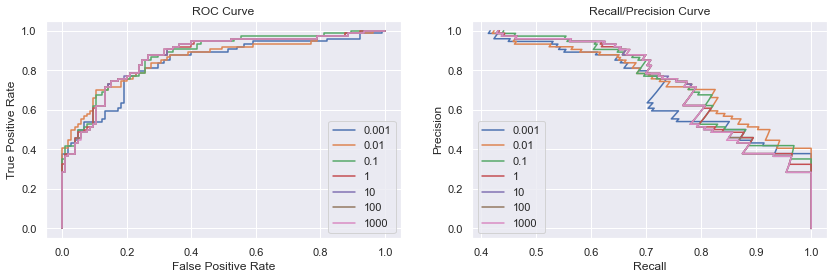

In [39]:
def cvalCurve(X, Y)  :
    
    c_values = [0.001,0.01,0.1,1,10,100,1000]
    for cval in c_values:
        
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

        standardscaler = StandardScaler()
        x_train = standardscaler.fit_transform(x_train)
        x_test = standardscaler.transform(x_test)

        logr = LogisticRegression(C = cval).fit(x_train, y_train)

        y_pred = logr.predict(x_test)
        y_prob = logr.predict_proba(x_test)[:,1]

        plt.subplot(1, 2, 1)
        fpr, tpr, thresholds  = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label = cval)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        plt.plot(precision, recall, label = cval)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Recall/Precision Curve')
        plt.legend()
    return
plt.figure(figsize=(14,4))
cvalCurve(X, Y)